# Music Taste Prediction Model: New Music Friday Recommender 💿🎧👍👎
In this model, I use my liked songs playlist, my recently loved and not loved albums, to train my regression model on what kind of music I do and don't like. At the end my test model will be the new music friday albums from the most recent Friday. 

# Library Imports

In [3]:
# Standard Library Imports
import os
import csv
from datetime import datetime
from time import sleep
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Tuple, Optional

# Third-Party Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from textblob import TextBlob
from transformers import pipeline

# Fuzzy Matching
from fuzzywuzzy import fuzz, process

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from nbconvert import HTMLExporter
import nbformat

# Streamlit 
import streamlit as st

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Load Datasets

In [5]:
df_liked = pd.read_csv("data/liked.csv")  # Liked playlist on Spotify
df_fav_albums = pd.read_csv("data/liked_albums.csv")  # Albums I've Liked in Recent Years
df_not_liked = pd.read_csv("data/did_not_like.csv")  # Albums I've not liked in Recent Years
df_nmf = pd.read_csv("data/nmf.csv")  # The most recent New Music Friday Playlist
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv') #Similar Artisits to My Liked Artists

## A Check for New Artists / Pull Their Similar Artists

In [7]:
# Initialize LastFM API client with rate limiting and request limits
# This ensures we don't overload the API and stay within usage guidelines ⏳
class LastFMAPI:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25, limit: int = 5):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        self.limit = limit

    # Fetch similar artists for a given artist from LastFM API
    # This is the core function that interacts with the API 🎤
    def get_similar_artists(self, artist_name: str) -> List[str]:
        params = {
            'method': 'artist.getSimilar',
            'artist': artist_name,
            'api_key': self.api_key,
            'limit': self.limit,  # Limit the number of similar artists returned 🎯
            'format': 'json'
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            
            # Handle rate limiting to avoid API bans ⚠️
            if 'X-RateLimit-Remaining' in response.headers:
                remaining = int(response.headers['X-RateLimit-Remaining'])
                if remaining == 0:
                    sleep(self.rate_limit_delay)
            
            # Extract and return similar artists from the API response 🎶
            data = response.json()
            if 'similarartists' in data and 'artist' in data['similarartists']:
                return [artist['name'] for artist in data['similarartists']['artist'][:self.limit]]
            return []
            
        except Exception as e:
            print(f"Error fetching similar artists for {artist_name}: {e}")
            return []

# Extract the primary artist name from a string
# This handles cases where multiple artists are listed (e.g., "Artist A, Artist B") 🎤
def extract_primary_artist(artist_string: str) -> str:
    if pd.isna(artist_string):
        return ""
    return artist_string.split(",")[0].strip()

# Update the similar artists database with new artists from liked playlists
# This function ensures the database stays up-to-date with my latest music preferences 🔄
def update_similar_artists(liked_path: str, 
                         albums_path: str, 
                         output_path: str, 
                         api_key: str) -> pd.DataFrame:
    print("Loading existing and new data...")
    
    # Load existing similar artists data
    # This ensures we don't duplicate work for artists already in the database 📂
    existing_data: Dict[str, List[str]] = {}
    if os.path.exists(output_path):
        existing_df = pd.read_csv(output_path)
        existing_data = dict(zip(existing_df['Artist'], existing_df['Similar Artists']))
        print(f"Loaded {len(existing_data)} existing artists from database")
    
    # Load and process current playlists
    # This combines liked songs and albums into a single set of artists 🎧
    df_liked = pd.read_csv(liked_path)
    df_albums = pd.read_csv(albums_path)
    
    # Extract and combine primary artists
    current_artists = set(
        pd.concat([
            df_liked['Artist Name(s)'].apply(extract_primary_artist),
            df_albums['Artist Name(s)'].apply(extract_primary_artist)
        ]).unique()
    )
    current_artists.discard("")  # Remove empty strings
    
    # Find new artists not in existing data
    # This ensures we only process artists we haven't seen before �
    new_artists = current_artists - set(existing_data.keys())
    print(f"Found {len(new_artists)} new artists to process")
    
    if not new_artists:
        print("No new artists to process. Database is up to date!")
        # Create and return DataFrame even if no updates
        return pd.DataFrame({
            'Artist': list(existing_data.keys()),
            'Similar Artists': list(existing_data.values())
        })
    
    # Initialize LastFM API client
    # This is where the magic happens ✨
    api = LastFMAPI(api_key)
    
    # Process artists with concurrent requests
    # This speeds up the process by fetching data in parallel ⚡
    results = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {
            executor.submit(api.get_similar_artists, artist): artist 
            for artist in new_artists
        }
        
        # Show progress bar while processing
        # This keeps you informed about the progress of the task 📊
        for future in tqdm(as_completed(future_to_artist), 
                         total=len(future_to_artist),
                         desc="Fetching similar artists"):
            artist = future_to_artist[future]
            similar_artists = future.result()
            results[artist] = ', '.join(similar_artists)
    
    # Combine existing and new data
    # This ensures the final dataset includes all artists, old and new 🔗
    combined_data = {**existing_data, **results}
    
    # Create DataFrame
    # This formats the data for easy saving and future use 📄
    output_df = pd.DataFrame({
        'Artist': list(combined_data.keys()),
        'Similar Artists': list(combined_data.values())
    })
    
    # Save updated data
    # This ensures the database is persisted for future runs 💾
    output_df.to_csv(output_path, index=False)
    print(f"Successfully updated database with {len(new_artists)} new artists")
    print(f"Total artists in database: {len(combined_data)}")
    
    return output_df

# Main execution block
# This runs the update process when the script is executed directly 🚀
if __name__ == "__main__":
    # Configuration
    API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"
    LIKED_PATH = "data/liked.csv"
    ALBUMS_PATH = "data/liked_albums.csv"
    OUTPUT_PATH = "data/liked_artists_only_similar.csv"
    
    # Run the update and get the DataFrame
    df_liked_similar = update_similar_artists(
        LIKED_PATH, 
        ALBUMS_PATH, 
        OUTPUT_PATH, 
        API_KEY
    )
    
# Now df_liked_similar is ready to use
# This displays the first few rows of the updated dataset 🎉
df_liked_similar.head()

Loading existing and new data...
Loaded 2140 existing artists from database
Found 0 new artists to process
No new artists to process. Database is up to date!


,Artist,Similar Artists
0,RY X,NaN
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh..."
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po..."
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq..."
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies..."


## Quick Glance at our Refreshed Datasets

In [9]:
df_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0zlVF45v1USPhSzmq558LF,Debbie Downer,Armageddon In A Summer Dress,Sunny War,2025-02-21,203000,20,NaN,2025-02-25T15:57:50Z,"folk punk,americana",...,4,-5.054,0,0.0326,0.0728,0.000147,0.1570,0.5990,90.770,4
1,3XFO3ezyuum0Ulxozpi2o3,Beautiful Trip,Infinity,Smif-N-Wessun,2025-02-21,184106,25,NaN,2025-02-22T21:11:10Z,"east coast hip hop,boom bap,hip hop",...,9,-7.415,0,0.2560,0.3710,0.006050,0.0737,0.4780,84.980,4
2,4FG86wYpIjIl5NrOr79Fxf,Tough Love,Flyte,"Flyte,Laura Marling",2023-10-27,181763,48,NaN,2025-02-21T03:05:09Z,"singer-songwriter,chamber pop,folk,indie folk",...,2,-6.872,1,0.0288,0.6830,0.272000,0.1090,0.6160,119.942,4
3,5KWrRynsADgBtgqoPCh7kn,Words,Waking Up,"Storefront Church,Phoebe Bridgers",2023-02-03,325443,31,NaN,2025-02-20T04:35:16Z,"chamber pop,baroque pop",...,5,-10.978,1,0.0345,0.5330,0.026300,0.1070,0.0671,77.883,4
4,7nGN1Wu9kCaKUUdqBcY9NZ,Let Me Go (feat. Madison Cunningham),Let Me Go (feat. Madison Cunningham),"Deep Sea Diver,Madison Cunningham",2025-02-04,282200,39,NaN,2025-02-19T00:45:28Z,NaN,...,4,-4.924,0,0.0308,0.3040,0.000000,0.1140,0.3740,127.658,4


In [10]:
# Liked Albums in Recent Years
df_fav_albums.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0UOeq7bSskoJa4cJaJOmFS,Ticking,Letter to Self,SPRINTS,2024-01-05,186949,27,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-6.490,1.0,0.3440,0.02500,0.076500,0.0934,0.291,175.574,4.0
1,02bA26OEe0nNFyE3YcNx4K,Heavy,Letter to Self,SPRINTS,2024-01-05,207409,43,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-5.925,1.0,0.0591,0.00435,0.000738,0.0877,0.189,88.581,4.0
2,7IPDhCIQlpvxVxtC1Q7Jq4,Cathedral,Letter to Self,SPRINTS,2024-01-05,179694,27,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,7.0,-6.231,1.0,0.0473,0.00978,0.002700,0.0887,0.397,119.056,4.0
3,65fPteG9ctHt2rrJxlbMr8,Shaking Their Hands,Letter to Self,SPRINTS,2024-01-05,222489,25,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-5.658,0.0,0.0533,0.19900,0.108000,0.1330,0.551,89.485,4.0
4,4UgkFdXpJD0fhw06BMk0bz,Adore Adore Adore,Letter to Self,SPRINTS,2024-01-05,157766,32,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-4.401,0.0,0.2570,0.01070,0.000107,0.1010,0.402,176.054,4.0


In [11]:
# Albums Not Liked in Recent Years
df_not_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,54KEm0VI9i3ic7VHHKHKRx,¿Cómo Así?,ORQUÍDEAS,Kali Uchis,2024-01-12,169654,54,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,6.0,-7.662,0.0,0.0892,0.04170,0.346000,0.154,0.379,135.985,4.0
1,5mVkTPlTPxlQOn7kEvuM3j,Me Pongo Loca,ORQUÍDEAS,Kali Uchis,2024-01-12,177815,51,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,7.0,-8.680,0.0,0.0426,0.03710,0.152000,0.106,0.407,114.999,4.0
2,6XaJfhwof7qIgbbXO5tIQI,Igual Que Un Ángel (with Peso Pluma),ORQUÍDEAS,"Kali Uchis,Peso Pluma",2024-01-12,260370,74,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,"corrido,corridos tumbados,corridos bélicos,mús...",...,5.0,-5.340,0.0,0.0320,0.00449,0.000663,0.185,0.482,108.001,4.0
3,52x8HIGuk1gGTlvO8CuLNS,Pensamientos Intrusivos,ORQUÍDEAS,Kali Uchis,2024-01-12,192027,58,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,9.0,-8.333,0.0,0.0394,0.57500,0.012900,0.110,0.511,119.994,4.0
4,3RleMgz4iO0BNezGdSxDnY,Diosa,ORQUÍDEAS,Kali Uchis,2024-01-12,156037,56,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,5.0,-5.518,0.0,0.0668,0.06750,0.000101,0.078,0.698,107.994,4.0


In [12]:
# New Music Friday Playlist
df_nmf.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,08aaQA6A7UHvbPGsfPrAFe,Praise,Sinister Grift,Panda Bear,2025-02-28,211126,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-28T14:13:47Z,psychedelic pop,...,10.0,-5.195,1.0,0.0353,0.01470,0.000002,0.3810,0.833,128.870,4.0
1,4t65DNY5AeBaoDiSQoALlE,Anywhere but Here,Sinister Grift,Panda Bear,2025-02-28,279972,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-28T14:13:47Z,psychedelic pop,...,1.0,-7.861,1.0,0.0298,0.39000,0.000003,0.1170,0.461,123.957,3.0
2,2TKDC967TRogQLg86tGw5b,50mg,Sinister Grift,Panda Bear,2025-02-28,274538,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-28T14:13:47Z,psychedelic pop,...,10.0,-6.908,0.0,0.0328,0.00253,0.000552,0.0956,0.746,133.014,4.0
3,0Krqcz9OB6G9wUUBL9BpGz,Ends Meet,Sinister Grift,Panda Bear,2025-02-28,201762,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-28T14:13:47Z,psychedelic pop,...,1.0,-5.302,1.0,0.0372,0.04940,0.000608,0.2350,0.852,114.030,4.0
4,0AN9lNRBYphPA1xNt48UZJ,Just as Well,Sinister Grift,Panda Bear,2025-02-28,213937,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-28T14:13:47Z,psychedelic pop,...,1.0,-6.400,1.0,0.0438,0.17200,0.002050,0.0894,0.940,149.934,3.0


In [13]:
# Similar Artists to Recently Played Artists (Last.fm)

df_liked_similar.head()

,Artist,Similar Artists
0,RY X,NaN
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh..."
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po..."
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq..."
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies..."


> A quick reminder of the standard columns of a spotify export.

In [15]:
df_liked.columns

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature'],
      dtype='object')

> What's available in the Similar dataframe?

In [17]:
df_liked_similar.columns

Index(['Artist', 'Similar Artists'], dtype='object')

### Add Target Labels for Training Feature
We need to assign a score to songs I've faved on spotify (100), albums I've enjoyed in recent years (65), and albums that I have not enjoyed in recent years (30) to train the model on the types of songs I don't like, like, and love. 'liked' will be our target variable, later.

In [19]:
# Assign liked scores before combining
df_liked['liked'] = 100
df_fav_albums['liked'] = 65
df_not_liked['liked'] = 30
df_nmf['liked'] = np.nan 

# Add playlist_origin column before combining
df_liked['playlist_origin'] = 'df_liked'
df_fav_albums['playlist_origin'] = 'df_fav_albums'
df_not_liked['playlist_origin'] = 'df_not_liked'
df_nmf['playlist_origin'] = 'df_nmf'
df_liked_similar['source'] = 'liked_similar'

### Check application of the target encoding

In [21]:
df_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,100,df_liked
1,100,df_liked
2,100,df_liked
3,100,df_liked
4,100,df_liked


In [22]:
df_fav_albums[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,65,df_fav_albums
1,65,df_fav_albums
2,65,df_fav_albums
3,65,df_fav_albums
4,65,df_fav_albums


In [23]:
df_not_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,30,df_not_liked
1,30,df_not_liked
2,30,df_not_liked
3,30,df_not_liked
4,30,df_not_liked


In [24]:
df_nmf[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,NaN,df_nmf
1,NaN,df_nmf
2,NaN,df_nmf
3,NaN,df_nmf
4,NaN,df_nmf


In [25]:
df_liked_similar[['Artist', 'Similar Artists', 'source']].head()

,Artist,Similar Artists,source
0,RY X,NaN,liked_similar
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh...",liked_similar
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po...",liked_similar
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq...",liked_similar
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies...",liked_similar


## Data Cleaning 🧹
Before diving into modeling, I need to clean and prepare the data to ensure it’s ready for analysis. This section focuses on merging my datasets, handling duplicates, filling missing values, and making sure the data is in the best possible shape. Here’s what I’ll tackle:

1. **Merging Datasets**: I’ll combine my liked songs, favorite albums, not-liked albums, and New Music Friday tracks into a single dataframe.
2. **Removing Duplicates**: I’ll ensure each track is unique, prioritizing higher "liked" scores for duplicates.
3. **Handling Missing Values**: I’ll fill gaps in genres using Last.fm’s richer data and save a backup of missing artists for manual review later.
4. **Dropping Irrelevant Columns**: I’ll remove columns that won’t contribute to the model.
5. **Final Checks**: I’ll verify the dataset’s integrity and distribution before moving to modeling.

By the end of this section, I’ll have a clean, unified dataset ready for feature engineering and model training. Let’s get started! 🚀

## Merge The Datasets

In [28]:
df = pd.concat([df_liked, df_fav_albums, df_not_liked, df_nmf], ignore_index=True)

In [29]:
#How Large is the Dataset, Now?
df.shape

(14006, 25)

#### Remove the Duplicates 🔥

In [31]:
# Remove duplicates: Keep the highest 'liked' score (100 > 65)
df = df.sort_values(by='liked', ascending=False)  # Ensures 100-rated songs come first
df = df.drop_duplicates(subset=['Track Name', 'Artist Name(s)'], keep='first')
df.shape

(11756, 25)

#### Drop columns that won't help the model 💣

In [33]:
df.drop(columns=['Added By', 'Added At', 'Time Signature'], inplace=True)

#### Handle missing values (if any)

In [35]:
 df.isna().sum()

Track ID               0
Track Name             0
Album Name             0
Artist Name(s)         0
Release Date           0
Duration (ms)          0
Popularity             0
Genres              5713
Record Label           3
Danceability           9
Energy                 9
Key                    9
Loudness               9
Mode                   9
Speechiness            9
Acousticness           9
Instrumentalness       9
Liveness               9
Valence                9
Tempo                  9
liked                632
playlist_origin        0
dtype: int64

## Getting New Genre Data From Last.fm 🟢🎵
Since half of the genres are missing from Spotify songs, I decided to use the richer data from Last.fm's crowd-sourced genre tags. There are some silly tags in there, so I added a list of ignored tags that I update weekly based on what I see in the data. This ensures the genres are meaningful and relevant for my model.

In [37]:
class LastFMGenreFetcher:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        
        # Define tags to ignore
        # These are the crowd-sourced tags that are more about personal taste than actual genres
        self.ignored_tags = {
            'seen live',
            'albums i own',
            'favorite',
            'favourites',
            'favourite',
            'my playlist',
            'spotify',
            'pandora',
            'wish i had seen live',
            'awesome',
            'love at first listen',
            'love',
            'amazing',
            'listened',
            'personal',
            'my music'
        }
        
        # Define variations of female vocalist to standardize
        # Because Last.fm users love to tag the same thing in 10 different ways 🎤
        self.female_vocalist_variants = {
            'female vocalists',
            'female vocalist',
            'female vocals',
            'female fronted',
            'female voices',
            'female voice',
            'female singers',
            'female singer'
        }
        
    def _make_request(self, params: Dict) -> Dict:
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            sleep(self.rate_limit_delay)  # Basic rate limiting to avoid angering the Last.fm API gods
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed for params {params}: {e}")
            if getattr(response, 'status_code', None) == 429:
                print("Rate limit exceeded, increasing delay. Patience is a virtue!")
                self.rate_limit_delay *= 2
                sleep(5)  # Wait before retry
            return None

    def get_artist_tags(self, artist_name: str) -> List[str]:
        params = {
            'method': 'artist.getTopTags',
            'artist': artist_name,
            'api_key': self.api_key,
            'format': 'json'
        }
        data = self._make_request(params)
        
        if not data or 'toptags' not in data:
            return []  # Sometimes Last.fm just doesn't have the data 🤷‍♂️
            
        tags = []
        seen_tags = set()  # Track unique tags to avoid duplicates
        has_female_vocalist = False
        
        for tag in data['toptags'].get('tag', []):
            tag_name = tag['name'].lower()
            
            # Skip if tag is in ignored list
            if tag_name in self.ignored_tags:
                continue  # Bye-bye, irrelevant tags!
                
            # Handle female vocalist variations
            if tag_name in self.female_vocalist_variants:
                if not has_female_vocalist:
                    tags.insert(0, 'female vocalist')  # Standardize and prioritize this tag
                    has_female_vocalist = True
                continue
            
            # Only add tag if we haven't seen it before
            if tag_name not in seen_tags:
                tags.append(tag_name)
                seen_tags.add(tag_name)
                
        return tags[:10]  # Return up to 10 tags because less is more, right?

def update_genre_data(api_key: str, dataframes: List[pd.DataFrame], output_file: str = 'data/ten_genres.csv') -> None:
    # Initialize the API client
    api = LastFMGenreFetcher(api_key)
    
    # Get all unique artists from the dataframes
    all_artists = set()
    for df in dataframes:
        if 'Artist Name(s)' in df.columns:
            artists = df['Artist Name(s)'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else None)
            all_artists.update(artist for artist in artists if artist)
    
    # Load existing data
    existing_data = {}
    try:
        if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
            existing_data = pd.read_csv(output_file).set_index('Artist')['Genres'].to_dict()
    except (pd.errors.EmptyDataError, KeyError):
        print("No existing genre data found or file is empty. Starting fresh. A blank slate!")
    
    # Load obscure artist genres and merge
    # Because Mike has some *very* specific tastes 🎸
    obscure_artists = pd.read_csv("data/obscure_artists_mike_likes.csv", quotechar='"')
    obscure_artists_dict = pd.Series(obscure_artists["Genres"].values, index=obscure_artists["Artist"]).to_dict()
    
    # Merge genres from obscure artists with existing data
    existing_data.update(obscure_artists_dict)
    
    # Identify new artists that aren't in existing data or obscure_artists
    new_artists = [artist for artist in all_artists if artist not in existing_data]
    
    if not new_artists:
        print("No new artists to process! Time for a coffee break ☕")
        return
    
    print(f"Found {len(new_artists)} new artists to process. Let's get to work!")
    
    # Process new artists with ThreadPoolExecutor
    # Because we're fancy and like to parallelize things 🚀
    results = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {executor.submit(api.get_artist_tags, artist): artist 
                          for artist in new_artists}
        
        completed = 0
        for future in as_completed(future_to_artist):
            artist = future_to_artist[future]
            try:
                tags = future.result()
                if tags:
                    results[artist] = ', '.join(tags)
                completed += 1
                if completed % 50 == 0 or (len(new_artists) < 50 and completed % 10 == 0):
                    print(f"Processed {completed}/{len(new_artists)} artists. Making progress!")
            except Exception as e:
                print(f"Error processing {artist}: {e}. Oops, better luck next time!")
    
    # Combine existing and new data
    all_data = {**existing_data, **results}
    
    # Save to CSV
    df_output = pd.DataFrame(
        [{'Artist': artist, 'Genres': genres} 
         for artist, genres in all_data.items()]
    )
    df_output.to_csv(output_file, index=False)
    print(f"\nSuccessfully updated {output_file} with {len(results)} new artists! High five! 🙌")

# Example usage:
if __name__ == "__main__":
    API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'  # Shh, don't share this!

    # Update genre data
    update_genre_data(API_KEY, [df], 'data/ten_genres.csv')

    # Load the ten_genres.csv file
    ten_genres = pd.read_csv("data/ten_genres.csv")

    # Extract the primary artist (before the comma)
    df["Primary Artist"] = df["Artist Name(s)"].str.split(",").str[0]
    ten_genres["Primary Artist"] = ten_genres["Artist"].str.split(",").str[0]

    # Merge, prioritizing ten_genres
    df = df.merge(ten_genres[["Primary Artist", "Genres"]], on="Primary Artist", how="left", suffixes=("", "_ten"))

    # If ten_genres has a match, use it; otherwise, keep the original
    df["Genres"] = df["Genres_ten"].combine_first(df["Genres"])

    # Drop the extra columns
    df.drop(columns=["Genres_ten", "Primary Artist"], inplace=True)

Found 73 new artists to process. Let's get to work!
Processed 50/73 artists. Making progress!

Successfully updated data/ten_genres.csv with 0 new artists! High five! 🙌


### Save a Copy of the Missing Genre Artists (Just in Case I Want to Fuss With It Later!) 🕵️‍♂️🎶
Even with Last.fm’s extensive data, some artists still slip through the cracks. To handle these edge cases, I’m saving a list of artists with missing genre data to a separate file. This way, I can manually review and assign genres later if needed. Think of it as a backup plan for those hard-to-categorize artists! 🎧✨

In [39]:
# Load the ten_genres.csv file
ten_genres = pd.read_csv("data/ten_genres.csv")

# Extract the primary artist from both datasets
# For artists with collaborators, we focus on the first name listed 🎤
df["Primary Artist"] = df["Artist Name(s)"].str.split(",").str[0].str.strip()
ten_genres["Primary Artist"] = ten_genres["Artist"].str.split(",").str[0].str.strip()

# Identify missing artists
# These are the artists not found in the ten_genres.csv file 🎸
missing_artists = df[~df["Primary Artist"].isin(ten_genres["Primary Artist"])]

# Save the missing artists to a CSV file
# This allows for manual review and genre assignment later 🕵️‍♂️
missing_artists[["Primary Artist"]].drop_duplicates().to_csv("data/missing_artists.csv", index=False)

print(f"Saved {len(missing_artists)} missing artists to 'data/missing_artists.csv'.")

# The missing artists are now stored in data/missing_artists.csv.
# If needed, I can manually assign genres and add them to
# obscure_artists_mike_likes.csv for future runs. A little manual effort goes a long way! 🎛️

Saved 175 missing artists to 'data/missing_artists.csv'.


In [40]:
#How many songs still have missing genre data?
df.isna().sum()

Track ID              0
Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres              120
Record Label          3
Danceability          9
Energy                9
Key                   9
Loudness              9
Mode                  9
Speechiness           9
Acousticness          9
Instrumentalness      9
Liveness              9
Valence               9
Tempo                 9
liked               632
playlist_origin       0
Primary Artist        0
dtype: int64

In [41]:
# Drop rows with nulls in any column except 'liked' because those belong to playlist_origin = df_nmf
df = df[df.drop(columns=['liked']).notna().all(axis=1)].reset_index(drop=True)

In [42]:
 df.isna().sum()

Track ID              0
Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres                0
Record Label          0
Danceability          0
Energy                0
Key                   0
Loudness              0
Mode                  0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
liked               616
playlist_origin       0
Primary Artist        0
dtype: int64

In [43]:
df.shape

(11625, 23)

In [44]:
# Count how many tracks belong to each 'playlist_origin' in the dataset
# This helps us understand the distribution of tracks across different sources 🎵
playlist_origin_counts = df['playlist_origin'].value_counts()

# Print the results
print("Playlist Origin Counts:")
playlist_origin_counts

Playlist Origin Counts:


playlist_origin
df_fav_albums    5575
df_liked         4069
df_not_liked     1365
df_nmf            616
Name: count, dtype: int64

## Feature Engineering / Further Selecting 👌

### 'Record Label Frequency Encoded' 🏷️

To improve the model’s ability to generalize, I’m creating a new feature: **Record Label Frequency Encoded**. This feature represents how frequently each record label appears in the dataset, but with a twist—we only consider labels from tracks I’ve liked or marked as favorite albums. This ensures the encoding reflects my preferences and ignores labels from tracks I don’t care about.

#### How It Works:
1. **Training Data Preparation**: We filter the combined dataframe (`df`) by `playlist_origin` to get subsets for `df_liked` and `df_fav_albums`. This ensures we’re working with the most up-to-date data.
2. **Frequency Calculation**: We count how often each record label appears in the training data (i.e., liked and favorite albums).
3. **Handling Unseen Labels**: For labels not present in the training data (e.g., those in the NMF test set), we use the **mean frequency** of all labels as a fallback. This ensures the model can handle new or rare labels gracefully.
4. **Application**: We apply the encoding to both the training and test sets, ensuring consistency across the data.

#### Why This Matters:
- **Relevance**: By focusing only on labels from tracks I like, the encoding better reflects my preferences.
- **Robustness**: Using the mean frequency for unseen labels ensures new artists from rare labels won't be penalized.
- **Simplicity**: Frequency encoding avoids the complexity of one-hot encoding while still capturing meaningful information.

This approach ensures the model learns from the distribution of labels I care about while remaining robust to new or rare labels.

In [47]:
# Filter the combined dataframe by playlist_origin to get the relevant subsets
# We focus on liked and favorite albums for training, ignoring disliked tracks 🚫
df_liked_subset = df[df['playlist_origin'] == 'df_liked']
df_fav_albums_subset = df[df['playlist_origin'] == 'df_fav_albums']
df_not_liked_subset = df[df['playlist_origin'] == 'df_not_liked']
df_nmf_subset = df[df['playlist_origin'] == 'df_nmf']

# Create a dataframe with only liked and favorite albums for training
# We exclude disliked tracks because their labels aren't relevant to my preferences 🎯
df_train_only = pd.concat([df_liked_subset, df_fav_albums_subset], ignore_index=True)

# Calculate frequency encoding using only liked and favorite albums
# This ensures the encoding reflects the distribution of labels I care about 🏷️
freq_encoding = df_train_only['Record Label'].value_counts()

# Get the mean frequency to use for unseen labels
# This acts as a fallback for labels not present in the training data 🛠️
mean_freq = freq_encoding.mean()

# Apply encoding to training data
df_train_only['Record Label Frequency Encoded'] = df_train_only['Record Label'].map(freq_encoding)

# Apply encoding to NMF data (test set), using the mean frequency for unseen labels
df_nmf_subset['Record Label Frequency Encoded'] = df_nmf_subset['Record Label'].map(freq_encoding).fillna(mean_freq)
df.loc[df['playlist_origin'] == 'df_nmf', 'Record Label Frequency Encoded'] = df_nmf_subset['Record Label Frequency Encoded']

# Apply encoding to the main dataframe for consistency
df['Record Label Frequency Encoded'] = df['Record Label'].map(freq_encoding).fillna(mean_freq)

# Check the result by displaying 20 Unique Record Labels and Their Encoding!
df[['Record Label', 'Record Label Frequency Encoded']].drop_duplicates().head(20)

,Record Label,Record Label Frequency Encoded
0,"New West Records, LLC",11.0
1,Forward Music Group,10.0
2,felte,9.0
3,Dead Oceans,140.0
4,Never Fall Back Records,11.0
5,22TWENTY,11.0
6,Jealous Butcher Records,2.0
7,Fiction Records,28.0
9,Cub Sport Records / Believe,1.0
13,New West Records,73.0


### Target Encode Genres 🎚

To capture the relationship between genres and the target variable (liked), I use target encoding. This technique replaces each genre (or combination of genres) with the mean target value for that genre, smoothed to handle rare categories. This gives me a "fingerprint" of how much I tend to like songs from each genre, which helps the model make better predictions.

#### Key Features:
- **Handling Multi-Genre Tracks**: Tracks with multiple genres are split, encoded individually, and then aggregated.
- **Smoothing**: I smooth the encoding to prevent overfitting by balancing genre-specific means with the global mean.
- **Rare Genres**: Genres that appear fewer than 28 times are grouped into a common "Rare_Genre" category.
- **Unknown Genres**: Tracks with "Unknown" genres are handled separately, using the global mean or a fallback value for NMF rows.

In [69]:
def target_encode_multi_genre(df, genre_column, target, smoothing=1, aggregation_method='mean'):
    """
    Target encode a multi-genre column and apply to all rows including NMF
    """
    # Separate training data (exclude NMF)
    df_train = df[df['playlist_origin'] != 'df_nmf'].copy()
    
    # Calculate global mean for fallback
    global_mean = df_train[target].mean()
    
    # Create genre-to-encoding mapping from training data
    
    # Split genres into individual categories
    df_train['split_genres'] = df_train[genre_column].str.split(', ').apply(
        lambda x: [genre for genre in x if genre != 'seen live' and genre != 'Unknown'] if isinstance(x, list) else x
    )
    
    # Explode the list of genres
    exploded_genres = df_train.explode('split_genres')
    
    # Calculate target encoding for individual genres
    label_means = exploded_genres.groupby('split_genres')[target].mean()
    label_counts = exploded_genres['split_genres'].value_counts()
    
    # Calculate smoothed target encoding
    smoothed_values = (label_means * label_counts + global_mean * smoothing) / (label_counts + smoothing)
    
    # Create a dictionary mapping for easy lookup
    genre_encoding_map = smoothed_values.to_dict()
    
    # Function to encode a list of genres for any row
    def encode_genres(genres_str):
        if pd.isna(genres_str) or genres_str == 'Unknown':
            return global_mean
            
        genres = genres_str.split(', ')
        genres = [g for g in genres if g != 'seen live' and g != 'Unknown']
        
        if not genres:
            return global_mean
            
        # Get encoding values for each genre
        genre_values = [genre_encoding_map.get(genre, global_mean) for genre in genres]
        
        # Apply aggregation
        if aggregation_method == 'mean':
            return sum(genre_values) / len(genre_values)
        elif aggregation_method == 'max':
            return max(genre_values)
        else:
            return sum(genre_values) / len(genre_values)  # Default to mean
    
    # Apply encoding to ALL rows including NMF
    df[genre_column + '_encoded'] = df[genre_column].apply(encode_genres)
    
    return df
# Run the improved target encoding function first
df = target_encode_multi_genre(df, 'Genres', 'liked', smoothing=35)

# Now check if NMF rows have values for Genres_encoded
nmf_encoding_check = df[df['playlist_origin'] == 'df_nmf'][['Track Name', 'Artist Name(s)', 'Genres', 'Genres_encoded']]

# Display stats about the encoding values
print(f"NMF rows total: {len(nmf_encoding_check)}")
print(f"NMF rows with genre encoding: {nmf_encoding_check['Genres_encoded'].notna().sum()}")
print(f"NMF rows missing genre encoding: {nmf_encoding_check['Genres_encoded'].isna().sum()}")

# Show the distribution of encoded values
if nmf_encoding_check['Genres_encoded'].notna().any():
    print("\nEncoding value stats:")
    print(f"Min: {nmf_encoding_check['Genres_encoded'].min()}")
    print(f"Max: {nmf_encoding_check['Genres_encoded'].max()}")
    print(f"Mean: {nmf_encoding_check['Genres_encoded'].mean()}")
    print(f"Median: {nmf_encoding_check['Genres_encoded'].median()}")
    
    # Display the first few rows to verify
    print("\nSample of encoded NMF rows:")
    print(nmf_encoding_check.head())
else:
    print("\nNo encoded values found in NMF rows.")

NMF rows total: 0
NMF rows with genre encoding: 0
NMF rows missing genre encoding: 0

No encoded values found in NMF rows.


### Finding How Central an Artist is to My Music Taste 🎯

To understand how central an artist is to my music taste, we’re building a network of artists based on which ones I’ve liked and which are similar to them. Using **PageRank**, a method that measures the importance of nodes in a network, we calculate each artist’s "centrality" score. This score reflects how influential an artist is within the network of my liked and similar artists.

#### Key Points:
- **Liked Artists**: Artists from my liked songs and favorite albums.
- **Similar Artists**: Artists similar to my liked artists (from `df_liked_similar`).
- **No Data Leakage**: The `df_nmf` (New Music Friday) artists are excluded from the network to avoid bias.
- **Scaled Scores**: Centrality scores are normalized to a 0-100 range for easier interpretation.

This approach ensures that the centrality scores are based solely on my preferences and not influenced by artists I haven’t liked or the New Music Friday playlist. Let’s dive into the code! 🚀

In [51]:
# First, create the Featured_Artist(s) column
def extract_featured_artists(df):
    # Create new column by splitting on comma and taking all but first artist
    df['Featured_Artist(s)'] = df['Artist Name(s)'].apply(
        lambda x: ', '.join(str(x).split(',')[1:]).strip() if ',' in str(x) else ''
    )
    return df

# Prepare the data
def prepare_featured_artists(df):
    # Prepare the 'Featured_Artist(s)' column for analysis.
    # Ensures the column exists, handles missing values, and splits into lists. 🧹
    # First create the column if it doesn't exist
    df = extract_featured_artists(df)
    
    # Ensure 'Featured_Artist(s)' is a string and handle missing values
    df['Featured_Artist(s)'] = df['Featured_Artist(s)'].fillna('').astype(str)
    
    # Split and clean the 'Featured_Artist(s)' column into lists
    df['Featured_Artist(s)'] = df['Featured_Artist(s)'].str.split(',').apply(
        lambda x: [artist.strip() for artist in x] if isinstance(x, list) else []
    )
    return df

def build_graph(df, df_liked_similar, include_nmf=False):
    # Build a graph of artists and their connections.
    # Only includes liked artists and their similar artists by default. 🎯
    # Optionally includes NMF and not-liked artists (without adding edges). 🚫
    G = nx.Graph()
    
    # Add nodes for liked artists
    liked_artists = set(
        df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]['Artist Name(s)']
        .str.split(',').explode().str.strip()
    )
    G.add_nodes_from(liked_artists, type='liked')
    
    # Add nodes for similar artists (from liked)
    similar_artists_liked = set(
        df_liked_similar['Similar Artists']
        .dropna()
        .str.split(',').explode().str.strip()
    )
    G.add_nodes_from(similar_artists_liked, type='similar_liked')
    
    # Add edges based on similarity (from liked)
    for _, row in df_liked_similar.iterrows():
        artist = row['Artist']
        if isinstance(row['Similar Artists'], str):
            similar = row['Similar Artists'].split(', ')
            for s in similar:
                G.add_edge(artist, s, weight=1.0)
    
    # Optionally include NMF and not-liked artists (without adding edges)
    if include_nmf:
        nmf_artists = set(
            df[df['playlist_origin'] == 'df_nmf']['Artist Name(s)']
            .str.split(',').explode().str.strip()
        )
        not_liked_artists = set(
            df[df['playlist_origin'] == 'df_not_liked']['Artist Name(s)']
            .str.split(',').explode().str.strip()
        )
        G.add_nodes_from(nmf_artists, type='nmf')
        G.add_nodes_from(not_liked_artists, type='not_liked')
    
    return G

def calculate_centrality_scores(G, df):
    # Calculate PageRank centrality for all artists in the graph.
    # Maps centrality scores back to the DataFrame for main artists. 📊
    centrality_scores = nx.pagerank(G)
    
    # Map centrality scores back to DataFrame for main artists
    df['Artist Centrality'] = (
        df['Artist Name(s)']
        .str.split(',').str[0].str.strip()
        .map(centrality_scores).fillna(0)
    )
    
    return df, centrality_scores

def normalize_centrality_scores(df):
    # Normalize centrality scores to a 0-100 range.
    # Ensures scores are interpretable and consistent. 🔢
    if df['Artist Centrality'].max() != 0:
        df['Artist Centrality'] = (df['Artist Centrality'] / df['Artist Centrality'].max()) * 100
    return df

# Run the complete pipeline
def run_centrality_analysis(df, df_liked_similar, include_nmf=False):
    # Run the complete centrality analysis pipeline:
    # 1. Prepare featured artists data.
    # 2. Build the graph.
    # 3. Calculate centrality scores.
    # 4. Normalize scores to 0-100 range. 🚀
    # Prepare the featured artists data (still needed to ensure the column exists)
    df = prepare_featured_artists(df)
    
    # Build the graph and calculate centrality
    G = build_graph(df, df_liked_similar, include_nmf=include_nmf)
    df, centrality_scores = calculate_centrality_scores(G, df)
    df = normalize_centrality_scores(df)
    
    return df, G, centrality_scores

# Execute the analysis for all artists (including NMF and not-liked)
df, G, centrality_scores = run_centrality_analysis(df, df_liked_similar, include_nmf=True)

# Extract the primary artist (first artist in 'Artist Name(s)' field
df['Primary Artist'] = df['Artist Name(s)'].str.split(',').str[0].str.strip()

# Now group by Primary Artist to ensure unique artists are considered
df_unique_artists = df.groupby('Primary Artist', as_index=False)['Artist Centrality'].max()

# Get the top 30 unique primary artists by their centrality score
top_artist_df = df_unique_artists.nlargest(30, 'Artist Centrality')[['Primary Artist', 'Artist Centrality']]

# Print the top 30 unique primary artists by centrality
print("\nTop 30 Unique Primary Artists by Centrality:")
top_artist_df


Top 30 Unique Primary Artists by Centrality:


,Primary Artist,Artist Centrality
1289,Molly Sarlé,100.000000
2111,WebsterX,93.055993
1785,String Machine,91.029804
249,Bob Dylan,90.061376
727,Generationals,90.050035
924,Jess Williamson,88.257920
308,Caamp,87.187867
332,Caroline Rose,86.831985
2060,Tyler,86.419957
608,Emily Watts,85.700956


### Distribution of Artist Centrality Scores by Playlist Origin 📊🎵

This histogram shows how **Artist Centrality** scores are distributed across different playlists. The centrality score reflects how central an artist is to my music taste, based on their connections to my liked artists and their similar artists.

- **Liked Artists (df_liked)**: Artists I’ve explicitly liked on Spotify.
- **Favorite Albums (df_fav_albums)**: Albums I’ve enjoyed in recent years.
- **Not Liked Albums (df_not_liked)**: Albums I didn’t enjoy in recent years.
- **New Music Friday (df_nmf)**: The most recent New Music Friday playlist.

#### What We’re Looking For:
- **High Centrality Scores**: Artists who are closely connected to my liked artists.
- **Low Centrality Scores**: Artists who are less connected to my preferences.
- **Patterns by Playlist**: Do certain playlists (e.g., liked vs. not liked) have distinct centrality distributions?

This visualization helps us understand how my preferences are reflected in the network of artists and how new or not-liked artists compare to my favorites. 🕵️‍♂️✨

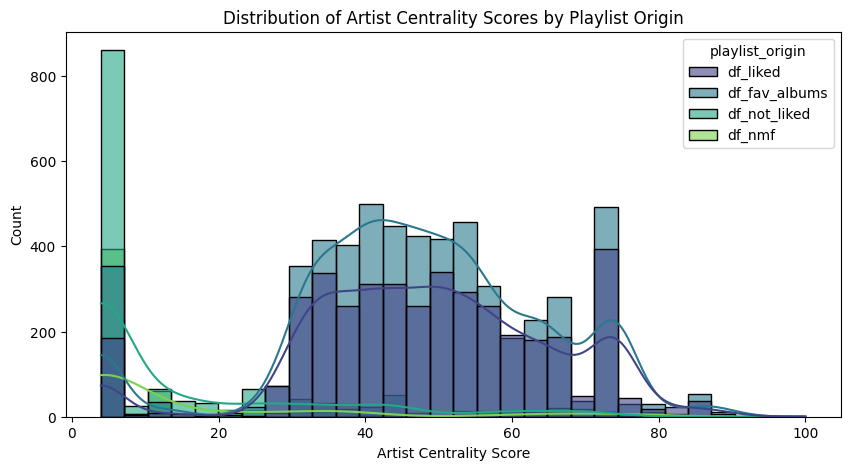

In [53]:
# Set figure size
plt.figure(figsize=(10, 5))

# Plot the distribution of 'Artist Centrality', colored by playlist_origin
# This shows how centrality scores vary across different playlists 🎨
sns.histplot(df, x='Artist Centrality', bins=30, hue='playlist_origin', kde=True, alpha=0.6, palette='viridis')

# Labels and title
plt.xlabel('Artist Centrality Score')
plt.ylabel('Count')
plt.title('Distribution of Artist Centrality Scores by Playlist Origin')

# Show the plot
plt.show()

### Lucy Dacus is one of my most played artists of all time, let's look at what her Pagerank network looked like!

In [55]:
# Extract Lucy Dacus's centrality score
lucy_dacus_centrality = df[df['Artist Name(s)'].str.contains('Lucy Dacus')]['Artist Centrality'].values[0]

# Extract Lucy Dacus's connections from the graph
lucy_dacus_connections = list(G.edges('Lucy Dacus'))

# Print Lucy Dacus's centrality score and connections
print(f"Lucy Dacus's Centrality Score: {lucy_dacus_centrality:.2f}")
print(f"Lucy Dacus's Connections: {lucy_dacus_connections}")

Lucy Dacus's Centrality Score: 3.94
Lucy Dacus's Connections: [('Lucy Dacus', 'Leith Ross'), ('Lucy Dacus', 'The Last Dinner Party'), ('Lucy Dacus', 'Mitski'), ('Lucy Dacus', 'Julien Baker'), ('Lucy Dacus', 'Boygenius'), ('Lucy Dacus', 'Phoebe Bridgers'), ('Lucy Dacus', 'Better Oblivion Community Center'), ('Lucy Dacus', 'Soccer Mommy'), ('Lucy Dacus', 'Hozier'), ('Lucy Dacus', 'Faye Webster'), ('Lucy Dacus', 'Julia Jacklin'), ('Lucy Dacus', 'Maya Hawke'), ('Lucy Dacus', 'Big Red Machine')]


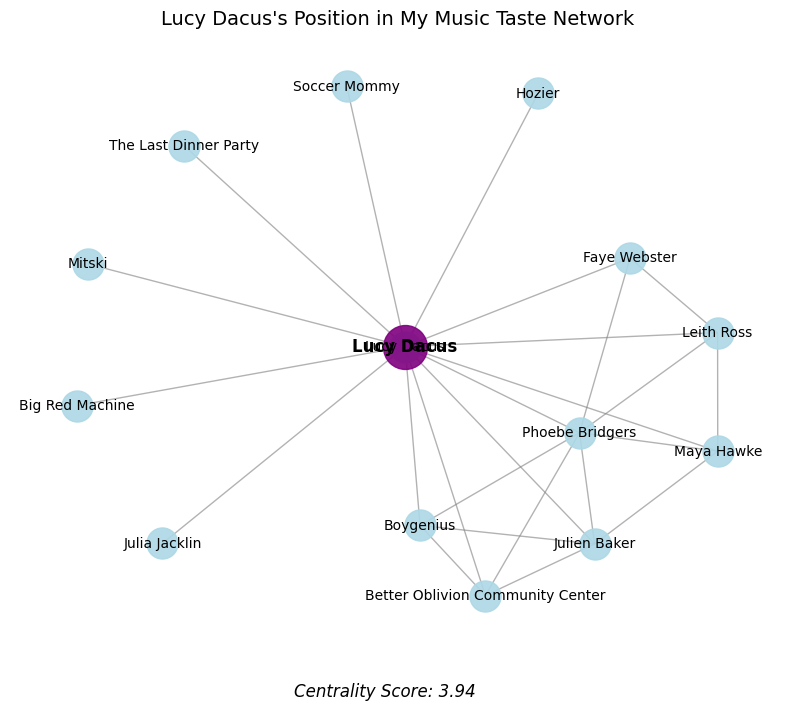

In [56]:
# Create a subgraph centered around Lucy Dacus
lucy_dacus_subgraph = G.subgraph(['Lucy Dacus'] + [artist for edge in lucy_dacus_connections for artist in edge])

# Set up the plot
plt.figure(figsize=(10, 8))

# Draw the network
pos = nx.spring_layout(lucy_dacus_subgraph, seed=42)  # Layout for consistent positioning
nx.draw_networkx_nodes(lucy_dacus_subgraph, pos, node_size=500, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(lucy_dacus_subgraph, pos, edge_color='gray', alpha=0.6)

# Highlight Lucy Dacus
nx.draw_networkx_nodes(lucy_dacus_subgraph, pos, nodelist=['Lucy Dacus'], node_size=1000, node_color='purple', alpha=0.9)
nx.draw_networkx_labels(lucy_dacus_subgraph, pos, labels={'Lucy Dacus': 'Lucy Dacus'}, font_size=12, font_weight='bold')

# Add labels for connected artists
nx.draw_networkx_labels(lucy_dacus_subgraph, pos, font_size=10)

# Add title and annotations
plt.title("Lucy Dacus's Position in My Music Taste Network", fontsize=14)
plt.figtext(0.5, 0.05, f"Centrality Score: {lucy_dacus_centrality:.2f}", ha='center', fontsize=12, style='italic')

# Remove axes
plt.axis('off')

# Show the plot
plt.show()

## Two More Features Before Primetime! 🎭

**Mood Score**: Combines Valence, Danceability, and Liveness to capture the vibe.

**Energy Profile**: Mashes Energy, Loudness, and Tempo to gauge the track’s intensity.


In [58]:
# Calculate features only on non-NMF data
non_nmf_df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Create mood_score and energy_profile on non-NMF data
non_nmf_df['mood_score'] = non_nmf_df[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
non_nmf_df['energy_profile'] = non_nmf_df[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

# Merge these features back into the main dataframe
df = df.merge(non_nmf_df[['mood_score', 'energy_profile']], how='left', left_index=True, right_index=True)

## Previwing the features on the menu 📖

In [60]:
df.columns

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Genres', 'Record Label',
       'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'liked', 'playlist_origin', 'Primary Artist',
       'Record Label Frequency Encoded', 'Genres_encoded',
       'Featured_Artist(s)', 'Artist Centrality', 'mood_score',
       'energy_profile'],
      dtype='object')

In [61]:
df.dtypes

Track ID                           object
Track Name                         object
Album Name                         object
Artist Name(s)                     object
Release Date                       object
Duration (ms)                       int64
Popularity                          int64
Genres                             object
Record Label                       object
Danceability                      float64
Energy                            float64
Key                               float64
Loudness                          float64
Mode                              float64
Speechiness                       float64
Acousticness                      float64
Instrumentalness                  float64
Liveness                          float64
Valence                           float64
Tempo                             float64
liked                             float64
playlist_origin                    object
Primary Artist                     object
Record Label Frequency Encoded    

## Standardize the numeric columns 📏
When some numbers have a larger size than others, the model can be biased towards them, so we bring all the numeric columns on a similar scale.

### Seperate New Music Friday and Save it for Later!

In [64]:
# Calculate mood and energy scores first
df['mood_score'] = df[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
df['energy_profile'] = df[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

# Split and save data
df_nmf = df[df['playlist_origin'] == 'df_nmf'].copy()
df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Save both versions pre-standardization
df_nmf.to_csv('data/df_nmf_later.csv', index=False)
df_cleaned_pre_standardized = pd.concat([df, df_nmf], ignore_index=True)
df_cleaned_pre_standardized.to_csv('data/df_cleaned_pre_standardized.csv', index=False)

# Store original values
original_centrality = df_nmf['Artist Centrality'].copy()
original_mood = df_nmf['mood_score'].copy()
original_energy = df_nmf['energy_profile'].copy()

In [65]:
# Define numeric columns to standardize
numeric_columns = [
    'Popularity', 
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'energy_profile'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data (df)
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Transform the test data (df_nmf) using the fitted scaler
df_nmf[numeric_columns] = scaler.transform(df_nmf[numeric_columns])

# Save the standardized df_nmf for later use
df_nmf.to_csv('data/df_nmf_later.csv', index=False)

In [66]:
df_nmf[numeric_columns].head()

,Popularity,Genres_encoded,Artist Centrality,Record Label Frequency Encoded,mood_score,energy_profile
11009,-1.143594,-0.740516,-1.557088,1.257023,1.922241,0.399956
11010,-1.143594,-0.740516,-1.557088,1.257023,0.180003,0.141568
11011,-1.143594,-0.740516,-1.557088,1.257023,0.950198,0.474193
11012,-1.143594,-0.740516,-1.557088,1.257023,1.760872,-0.093178
11013,-1.143594,-0.740516,-1.557088,1.257023,1.165721,1.047172


## Tuning and Predicting with Random Forest & XGBoost 🌟
In this section, we fine-tune our Random Forest and XGBoost models using randomized search for optimal hyperparameters. The goal? To get the best possible performance in predicting song ratings. After tuning the models, we make predictions on the unseen data, combining both models' results to generate a more accurate score!

In [86]:
def tune_models(df, features, test_size=0.2):
    # Prepare data
    X = df[features]
    y = (df['liked'] - df['liked'].mean()) / df['liked'].std()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # RandomForest parameters
    rf_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    
    # XGBoost parameters
    xgb_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }
    
    # Initialize models
    rf = RandomForestRegressor(random_state=42)
    xgb = XGBRegressor(random_state=42)
    
    # Perform randomized search
    rf_search = RandomizedSearchCV(
        rf, rf_params, n_iter=20, cv=5, scoring='neg_mean_squared_error',
        random_state=42, n_jobs=-1
    )
    xgb_search = RandomizedSearchCV(
        xgb, xgb_params, n_iter=20, cv=5, scoring='neg_mean_squared_error',
        random_state=42, n_jobs=-1
    )
    
    # Fit models
    rf_search.fit(X_train, y_train)
    xgb_search.fit(X_train, y_train)
    
    # Train final models with best parameters
    best_rf = RandomForestRegressor(**rf_search.best_params_, random_state=42)
    best_xgb = XGBRegressor(**xgb_search.best_params_, random_state=42)
    
    best_rf.fit(X_train, y_train)
    best_xgb.fit(X_train, y_train)
    
    return best_rf, best_xgb, rf_search.best_params_, xgb_search.best_params_

def predict_with_tuned_models(best_rf, best_xgb, df_nmf, features, y_mean, y_std):
    # Make predictions
    rf_pred = best_rf.predict(df_nmf[features]) * y_std + y_mean
    xgb_pred = best_xgb.predict(df_nmf[features]) * y_std + y_mean
    
    # Combine predictions
    df_nmf['predicted_score'] = (rf_pred + xgb_pred) / 2
    
    return df_nmf

# Usage
features  = [
    'Popularity', 
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'energy_profile'
]

best_rf, best_xgb, rf_params, xgb_params = tune_models(df, features)
df_nmf = predict_with_tuned_models(best_rf, best_xgb, df_nmf, features, df['liked'].mean(), df['liked'].std())

# Output best parameters and feature importances
print(f"Random Forest best parameters: {rf_params}")
print(f"XGBoost best parameters: {xgb_params}")
print(f"Random Forest feature importances: {best_rf.feature_importances_}")
print(f"XGBoost feature importances: {best_xgb.feature_importances_}")

# Feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance (Random Forest):")
print(feature_importance)

# Save outputs to CSV for future review
rf_params_df = pd.DataFrame([rf_params], index=['Random Forest'])
xgb_params_df = pd.DataFrame([xgb_params], index=['XGBoost'])
feature_importance.to_csv('feature_params/feature_importance.csv')
rf_params_df.to_csv('feature_params/rf_params.csv')
xgb_params_df.to_csv('feature_params/xgb_params.csv')

Random Forest best parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
XGBoost best parameters: {'colsample_bytree': 0.8404460046972835, 'learning_rate': 0.22242177333881366, 'max_depth': 8, 'n_estimators': 102, 'subsample': 0.9879639408647978}
Random Forest feature importances: [0.0673508  0.24396863 0.35275165 0.26321251 0.03588735 0.03682906]
XGBoost feature importances: [0.06505078 0.2287841  0.3192799  0.29540685 0.04738745 0.0440909 ]
Feature importance (Random Forest):
                          feature  importance
2               Artist Centrality    0.352752
3  Record Label Frequency Encoded    0.263213
1                  Genres_encoded    0.243969
0                      Popularity    0.067351
5                  energy_profile    0.036829
4                      mood_score    0.035887


# 80/20 Train/Test of The Non NMF Data using RandomForrest and XGBoost

In [89]:
def train_test_model(df, features):
    """
    Train and test model on non-NMF data using 80/20 split
    """
    # Only use non-NMF data for training
    train_df = df[df['playlist_origin'] != 'df_nmf'].copy()
    
    # Prepare features and target
    X = train_df[features]
    y = train_df['liked']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Initialize models with the best parameters from tuning
    rf_model = RandomForestRegressor(**rf_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_params, random_state=42)
    
    # Train models
    print("Training Random Forest model...")
    rf_model.fit(X_train, y_train)
    
    print("Training XGBoost model...")
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    # Combine predictions (80/20 weight)
    final_pred = (0.8 * rf_pred) + (0.2 * xgb_pred)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, final_pred)
    r2 = r2_score(y_test, final_pred)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Track Name': train_df.loc[X_test.index, 'Track Name'],
        'Artist Name(s)': train_df.loc[X_test.index, 'Artist Name(s)'],
        'Actual Score': y_test,
        'Predicted Score': final_pred
    })
    
    # Get feature importances
    importances = pd.DataFrame({
        'Feature': features,
        'RF Importance': rf_model.feature_importances_,
        'XGB Importance': xgb_model.feature_importances_
    })
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    print("\nTop 10 Predictions vs Actual:")
    print(results_df.sort_values('Predicted Score', ascending=False).head(10))
    
    print("\nFeature Importances:")
    print(importances.sort_values('RF Importance', ascending=False))
    
    return rf_model, xgb_model, results_df, importances

# To use the model:
# Usage
features  = [
    'Popularity', 
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'energy_profile'
]

# Run the model
rf_model, xgb_model, results, importances = train_test_model(df, features)


Training Random Forest model...
Training XGBoost model...

Model Performance:
Mean Squared Error: 168.39
R² Score: 0.68

Top 10 Predictions vs Actual:
                            Track Name  \
367                      Kitchen Floor   
3148                         The Boxer   
3853                               Hey   
3680                        Waxahachie   
3838  Sleepless Nights (feat. Phoelix)   
3011                    DEVIL IS A LIE   
3686                  Babies Are a Lie   
2406                The Weight of Lies   
1068                           Miracle   
1254                      In The Pines   

                                         Artist Name(s)  Actual Score  \
367                                      Jess Cornelius         100.0   
3148                                  Simon & Garfunkel         100.0   
3853                                              Falls         100.0   
3680                                    Miranda Lambert         100.0   
3838  Terrace Martin,

# Run the New Music Friday Regression Model
We’re using non-NMF data to train Random Forest and XGBoost models to predict how much people will like different tracks. After training, we make predictions for new tracks and give lesser-known artists an extra boost.

Next, we calculate confidence intervals to gauge how much we trust the predictions. We also aggregate results by album, factoring in consistency and track count, then sort by weighted score to create a list of top album recommendations.


=== New Music Friday Recommendations (2025-02-28) ===

Total albums: 54
Albums with 5+ tracks: 51
Albums filtered out (< 5 tracks): 3

Top 20 Albums by Average Score:
                     Artist                               Album Name  avg_score  Track_Count
                 The Chills Spring Board: The Early Unrecorded Songs     101.29           20
                Miya Folick                         Erotica Veronica      99.07           11
             Deep Sea Diver                          Billboard Heart      96.07           10
                  Andy Bell                         pinball wanderer      85.15            8
                  Cheekface                             Middle Spoon      70.54           12
                    Hana Vu                                   Movies      69.75            5
                    Hachiku          The Joys Of Being Pure At Heart      57.03           10
                     corook                       committed to a bit      48.22         

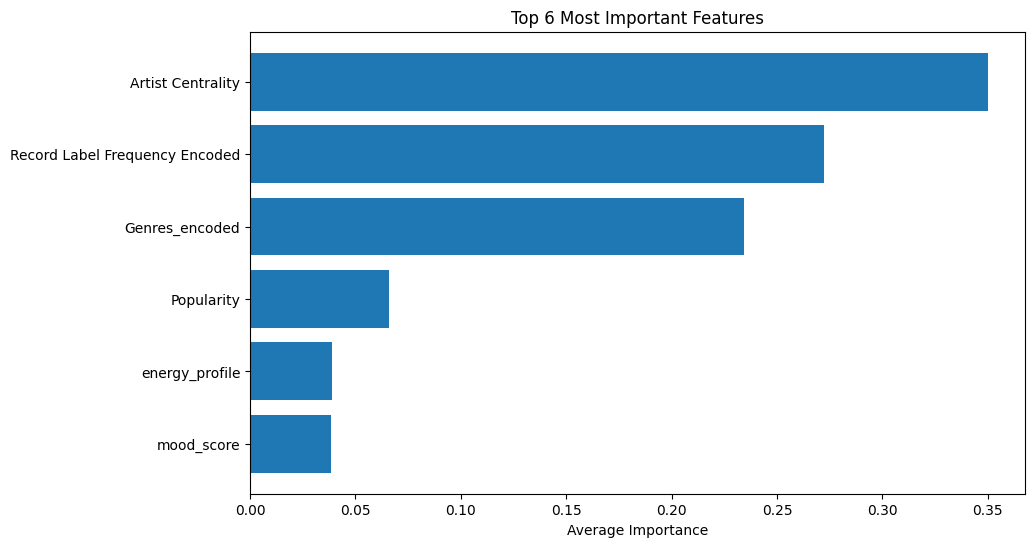

In [91]:
# Load the similar artists data
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv')

# Create known artists set
known_artists = set(df_liked_similar['Artist'])

# Usage
features  = [
    'Popularity', 
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'energy_profile'
]

# Normalize the target variable
y_mean = df['liked'].mean()
y_std = df['liked'].std()
y_normalized = (df['liked'] - y_mean) / y_std

# Prepare training data
X = df[features]
y = y_normalized  # Use normalized target

# Initialize models with the best parameters from tuning
rf_model = RandomForestRegressor(**rf_params, random_state=42)
xgb_model = XGBRegressor(**xgb_params, random_state=42)

# Train models
rf_model.fit(X, y)
xgb_model.fit(X, y)

# Get feature importance from both models
rf_importance = pd.DataFrame({
    'feature': features,
    'importance_rf': rf_model.feature_importances_
}).sort_values('importance_rf', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': features,
    'importance_xgb': xgb_model.feature_importances_
}).sort_values('importance_xgb', ascending=False)

# Combine importance scores
feature_importance = pd.merge(rf_importance, xgb_importance, on='feature')
feature_importance['avg_importance'] = (feature_importance['importance_rf'] + feature_importance['importance_xgb']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Prepare NMF data for prediction
df_nmf_cleaned = df_nmf[features]

# Make predictions and denormalize
rf_predictions = rf_model.predict(df_nmf_cleaned) * y_std + y_mean
xgb_predictions = xgb_model.predict(df_nmf_cleaned) * y_std + y_mean

# Combine predictions (ensemble)
final_predictions = (rf_predictions + xgb_predictions) / 2

# MODIFIED SECTION - Apply artist boost
df_nmf['is_unknown_artist'] = ~df_nmf['Artist Name(s)'].isin(known_artists)
df_nmf['predicted_score'] = final_predictions + (df_nmf['is_unknown_artist'] * 2.5)

# Get prediction intervals
def get_prediction_interval(X, model, percentile=95):
    predictions = []
    for estimator in model.estimators_:
        predictions.append(estimator.predict(X) * y_std + y_mean)
    predictions = np.array(predictions)
    lower = np.percentile(predictions, (100-percentile)/2, axis=0)
    upper = np.percentile(predictions, 100-(100-percentile)/2, axis=0)
    return lower, upper

# Calculate prediction intervals
lower_bound, upper_bound = get_prediction_interval(df_nmf_cleaned, rf_model)
df_nmf['prediction_lower'] = lower_bound
df_nmf['prediction_upper'] = upper_bound
df_nmf['prediction_uncertainty'] = upper_bound - lower_bound

# Get the most common release date from NMF dataset
nmf_release_date = df_nmf['Release Date'].mode().iloc[0]

album_predictions = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': 'first',
    'predicted_score': ['mean', 'std', 'count'],
    'prediction_uncertainty': 'mean',
    'Genres': lambda x: ' | '.join(list(set(x))[:3]),
    'Record Label': 'first',
    'Artist Centrality': 'first',  
    'mood_score': 'first',         
    'energy_profile': 'first'     
}).reset_index()


# Flatten column names
album_predictions.columns = [
    'Album Name', 'Artist', 'avg_score', 'score_std', 'track_count',
    'avg_uncertainty', 'Genres', 'Label', 'Artist_Centrality', 
    'Mood_Score', 'Energy_Profile'
]

# Calculate confidence score (unchanged)
max_std = album_predictions['score_std'].max()
max_uncertainty = album_predictions['avg_uncertainty'].max()

album_predictions['confidence_score'] = (
    (1 - album_predictions['score_std'] / max_std) * 
    (1 - album_predictions['avg_uncertainty'] / max_uncertainty) * 
    (1 - 1/(1 + album_predictions['track_count']))
) * 100

album_predictions['confidence_score'] = np.clip(
    album_predictions['confidence_score'], a_min=1, a_max=100
)

# Rename track_count to Track_Count in the album_predictions dataframe
album_predictions = album_predictions.rename(columns={'track_count': 'Track_Count'})

# Filter out albums with fewer than 5 tracks
album_predictions_filtered = album_predictions[album_predictions['Track_Count'] >= 5].copy()

# Sort by average score
album_recommendations = album_predictions_filtered.sort_values('avg_score', ascending=False)

# Define output columns with original values and add Track_Count
output_columns = [
    'Artist', 'Album Name', 'avg_score', 'confidence_score',
    'Track_Count', 'Genres', 'Label', 'Artist_Centrality', 
    'Mood_Score', 'Energy_Profile'
]

# Format the date for the filename
date_str = datetime.strptime(nmf_release_date, '%Y-%m-%d').strftime('%m-%d-%y')
filename = f"{date_str}_Album_Recommendations.csv"

# Save recommendations with rounded numbers and scale adjustments
final_recommendations = album_recommendations[output_columns].copy()
final_recommendations['Artist_Centrality'] = final_recommendations['Artist_Centrality'] * 100
final_recommendations['Mood_Score'] = final_recommendations['Mood_Score'].clip(0, 1) * 100
final_recommendations['Energy_Profile'] = final_recommendations['Energy_Profile'].clip(0, 1) * 100

final_recommendations.round(2).to_csv(f'predictions/{filename}', index=False)

# Define the custom scorer for cross-validation
def custom_scorer(y_true, y_pred):
    y_true_denormalized = y_true * y_std + y_mean
    y_pred_denormalized = y_pred * y_std + y_mean
    return -mean_squared_error(y_true_denormalized, y_pred_denormalized)

# Wrap the custom scorer
custom_scorer_func = make_scorer(custom_scorer, greater_is_better=False)

# Evaluate models using cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring=custom_scorer_func)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=custom_scorer_func)

# Print results with improved formatting
print(f"\n=== New Music Friday Recommendations ({nmf_release_date}) ===\n")

# Count of albums filtered out
albums_filtered_out = len(album_predictions) - len(album_predictions_filtered)
print(f"Total albums: {len(album_predictions)}")
print(f"Albums with 5+ tracks: {len(album_predictions_filtered)}")
print(f"Albums filtered out (< 5 tracks): {albums_filtered_out}\n")

# Display top 20 recommended albums with clean formatting
print("Top 20 Albums by Average Score:")
display_cols = ['Artist', 'Album Name', 'avg_score', 'Track_Count']
print(album_recommendations[display_cols].head(20).round(2).to_string(index=False))

# Print model performance metrics
print("\n=== Model Performance ===")
print(f"Random Forest CV Score: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
print(f"XGBoost CV Score: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std() * 2:.3f})")

# Display feature importance
print("\n=== Feature Importance ===")
print(feature_importance[['feature', 'avg_importance']].round(3).to_string(index=False))

# Visualization for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['avg_importance'])
plt.xlabel('Average Importance')
plt.title('Top 6 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Display the Top Recommended Albums!

In [93]:
# Folder where the predictions are saved
predictions_folder = "predictions/"

# Get the latest predictions file
files = [f for f in os.listdir(predictions_folder) if f.endswith("_Album_Recommendations.csv")]

if files:
    thisweek = max(files, key=lambda f: os.path.getmtime(os.path.join(predictions_folder, f)))
    print(f"Loaded latest file: {thisweek}")  # Optional, just for confirmation
    model_output_df = pd.read_csv(os.path.join(predictions_folder, thisweek))
    model_output_df = model_output_df.sort_values(by="avg_score", ascending=False)

    # Display all rows
    pd.set_option("display.max_rows", None)
    model_output_df
else:
    thisweek = None
    None  # Ensures no unwanted output

thisweek  # Stores the filename for reference
model_output_df  #Show the Recommendations Dataframe for This Past Week!

Loaded latest file: 02-28-25_Album_Recommendations.csv


,Artist,Album Name,avg_score,confidence_score,Track_Count,Genres,Label,Artist_Centrality,Mood_Score,Energy_Profile
0,The Chills,Spring Board: The Early Unrecorded Songs,101.29,67.61,20,"new zealand, indie pop, indie, flying nun, kiw...",Fire Records,115.60,0.00,100.00
1,Miya Folick,Erotica Veronica,99.07,5.22,11,"female vocalist, singer-songwriter, indie pop,...",Nettwerk Music Group,171.30,100.00,54.02
2,Deep Sea Diver,Billboard Heart,96.07,15.65,10,"female vocalist, indie, indie rock, folk, ambi...",Sub Pop Records,-29.23,0.00,0.84
3,Andy Bell,pinball wanderer,85.15,33.78,8,"female vocalist, synthpop, electronic, pop, br...",Sonic Cathedral,82.02,84.46,82.20
4,Cheekface,Middle Spoon,70.54,1.00,12,"indie rock, post-punk, power pop, indie, rock,...",Cheekface,-44.84,100.00,100.00
5,Hana Vu,Movies,69.75,1.00,5,"female vocalist, dream pop, indie, shoegaze, l...",Ghostly International,-8.09,0.00,36.69
6,Hachiku,The Joys Of Being Pure At Heart,57.03,19.94,10,"indie pop, indie, indie rock, dream pop, austr...",Marathon Artists,-192.26,93.57,100.00
7,corook,committed to a bit,48.22,20.61,13,"female vocalist, singer-songwriter, indie pop,...",Atlantic Records,-192.26,0.00,0.00
8,Ichiko Aoba,Luminescent Creatures,44.68,38.65,11,"female vocalist, folk, singer-songwriter, japa...",Psychic Hotline,-192.26,0.00,100.00
9,Architects,"The Sky, The Earth & All Between",44.49,57.05,12,"metalcore, mathcore, hardcore, metal, tech met...",Epitaph,-192.26,0.00,30.95


## Grab Album Art for the NMF Albums

In [95]:
# My Last.fm API key
LASTFM_API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"

# Function to get similar artists using Last.fm API
def get_similar_artists(artist: str, api_key: str, limit: int = 5) -> Dict:
    """
    Get similar artists using Last.fm API.
    Returns dict with artist and similar artists list.
    """
    base_url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        'method': 'artist.getsimilar',
        'artist': artist,
        'api_key': api_key,
        'limit': limit,
        'format': 'json'
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'similarartists' in data and 'artist' in data['similarartists']:
            similar_artists = [artist['name'] for artist in data['similarartists']['artist']]
            return {
                'Artist': artist,
                'Similar Artists': ", ".join(similar_artists[:limit]),
                'status': 'success'
            }
    except Exception as e:
        return {
            'Artist': artist,
            'Similar Artists': None,
            'status': f'error: {str(e)}'
        }
    
    return {
        'Artist': artist,
        'Similar Artists': None,
        'status': 'no_results'
    }

# Function to fetch album art from Discogs (backup)
def get_album_art_discogs(artist: str, album: str) -> str:
    """
    Fetch album artwork URL using Discogs API directly.
    """
    try:
        url = "https://api.discogs.com/database/search"
        params = {
            'artist': artist,
            'release_title': album,
            'type': 'release',
            'per_page': 1
        }
        headers = {
            'User-Agent': 'MyApp/1.0',  # Required by Discogs
            'Authorization': 'Discogs token=YOUR_DISCOGS_TOKEN'  
        }
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        if data.get('results') and data['results'][0].get('cover_image'):
            return data['results'][0]['cover_image']
    except Exception as e:
        print(f"Discogs error for {artist} - {album}: {e}")
    return None

# Function to get album art using Last.fm API (primary) and Discogs (backup)
def get_album_art(artist: str, album: str, api_key: str) -> Dict:
    """
    Search for album artwork URL using Last.fm API, with Discogs as a backup.
    Returns dict with album info and status.
    """
    base_url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        'method': 'album.getinfo',
        'api_key': api_key,
        'artist': artist,
        'album': album,
        'format': 'json'
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'album' in data and 'image' in data['album']:
            images = data['album']['image']
            largest_image = images[-1]['#text'] if images else None
            if largest_image:
                return {
                    'Artist': artist,
                    'Album Name': album,
                    'Album Art': largest_image,
                    'status': 'success (Last.fm)'
                }
        
        # If Last.fm fails, try Discogs as a backup
        discogs_art = get_album_art_discogs(artist, album)
        if discogs_art:
            return {
                'Artist': artist,
                'Album Name': album,
                'Album Art': discogs_art,
                'status': 'success (Discogs)'
            }
        
        # If both APIs fail
        return {
            'Artist': artist,
            'Album Name': album,
            'Album Art': None,
            'status': 'no_results'
        }
    except Exception as e:
        return {
            'Artist': artist,
            'Album Name': album,
            'Album Art': None,
            'status': f'error: {str(e)}'
        }

# Main function to update album data
def update_album_data(input_file: str, album_art_file: str, similar_artists_file: str, api_key: str) -> None:
    """
    Fetch fresh album cover art and similar artists data for the current playlist.
    """
    print(f"\nStarting data fetch at {datetime.now().strftime('%H:%M:%S')}")
    
    # Read input data
    df_input = pd.read_csv(input_file)
    
    # Get all unique artist/album pairs from the input data
    album_pairs = df_input[['Primary Artist', 'Album Name']].drop_duplicates()
    
    # Get all recommended artists (from df_nmf tracks)
    recommended_artists = df_input[df_input['playlist_origin'] == 'df_nmf']['Primary Artist'].unique()
    
    # Load existing album covers (if any)
    try:
        existing_album_art = pd.read_csv(album_art_file)
        print("Loaded existing album covers.")
    except FileNotFoundError:
        existing_album_art = pd.DataFrame(columns=['Artist', 'Album Name', 'Album Art'])
        print("No existing album covers found. Starting fresh.")
    
    # Filter out albums that already have artwork
    album_pairs = album_pairs.merge(
        existing_album_art,
        left_on=['Primary Artist', 'Album Name'],
        right_on=['Artist', 'Album Name'],
        how='left',
        indicator=True
    )
    album_pairs = album_pairs[album_pairs['_merge'] == 'left_only'].drop(columns=['_merge', 'Album Art'])
    
    if len(album_pairs) == 0:
        print("All albums already have artwork. No new data to process.")
    else:
        print(f"\nNeed to fetch album artwork for {len(album_pairs)} new albums.")
    
    # Initialize empty DataFrames for new data
    df_album_art = pd.DataFrame(columns=['Artist', 'Album Name', 'Album Art'])
    df_similar = pd.DataFrame(columns=['Artist', 'Similar Artists'])
    
    # Process album art for new albums
    print("\nFetching album artwork...")
    album_entries = []
    successful_albums = 0
    failed_albums = 0
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_album = {
            executor.submit(get_album_art, row['Primary Artist'], row['Album Name'], api_key): (row['Primary Artist'], row['Album Name'])
            for _, row in album_pairs.iterrows()
        }
        
        for i, future in enumerate(as_completed(future_to_album), 1):
            result = future.result()
            if result['status'].startswith('success') and result['Album Art']:
                album_entries.append({
                    'Artist': result['Artist'],
                    'Album Name': result['Album Name'],
                    'Album Art': result['Album Art']
                })
                successful_albums += 1
            else:
                failed_albums += 1
            
            if i % 5 == 0 or i == len(album_pairs):
                print(f"Album Progress: {i}/{len(album_pairs)} | Success: {successful_albums} | Failed: {failed_albums}")
            
            sleep(0.25)
    
    if album_entries:
        df_album_art = pd.DataFrame(album_entries)
        # Append new data to existing data
        updated_album_art = pd.concat([existing_album_art, df_album_art], ignore_index=True)
        updated_album_art.to_csv(album_art_file, index=False)
        print(f"Saved {len(df_album_art)} new album covers to {album_art_file}.")
    
    # Process similar artists for recommended artists
    print("\nFetching similar artists...")
    artist_entries = []
    successful_artists = 0
    failed_artists = 0
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_artist = {
            executor.submit(get_similar_artists, artist, api_key): artist
            for artist in recommended_artists
        }
        
        for i, future in enumerate(as_completed(future_to_artist), 1):
            result = future.result()
            if result['status'] == 'success' and result['Similar Artists']:
                artist_entries.append({
                    'Artist': result['Artist'],
                    'Similar Artists': result['Similar Artists']
                })
                successful_artists += 1
            else:
                failed_artists += 1
            
            if i % 5 == 0 or i == len(recommended_artists):
                print(f"Artist Progress: {i}/{len(recommended_artists)} | Success: {successful_artists} | Failed: {failed_artists}")
            
            sleep(0.25)
    
    if artist_entries:
        df_similar = pd.DataFrame(artist_entries)
        df_similar.to_csv(similar_artists_file, index=False)
        print(f"Saved {len(df_similar)} new similar artists to {similar_artists_file}.")
    
    print(f"\nFinished at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Summary:")
    print(f"- Album artwork added: {successful_albums}")
    print(f"- Album artwork failed: {failed_albums}")
    print(f"- Similar artists added: {successful_artists}")
    print(f"- Similar artists failed: {failed_artists}")
    print(f"- Total albums in database: {len(existing_album_art) + len(df_album_art)}")
    print(f"- Total artists in database: {len(df_similar)}")

# Usage
if __name__ == "__main__":
    input_file = "data/df_nmf_later.csv"  
    album_art_file = "data/nmf_album_covers.csv"  
    similar_artists_file = "data/nmf_similar_artists.csv"  
    update_album_data(input_file, album_art_file, similar_artists_file, LASTFM_API_KEY)


Starting data fetch at 21:24:28
Loaded existing album covers.

Need to fetch album artwork for 2 new albums.

Fetching album artwork...
Discogs error for Sahara Grim - Fable: 401 Client Error: Unauthorized for url: https://api.discogs.com/database/search?artist=Sahara+Grim&release_title=Fable&type=release&per_page=1
Discogs error for Bedrooms - Monkrooms: 401 Client Error: Unauthorized for url: https://api.discogs.com/database/search?artist=Bedrooms&release_title=Monkrooms&type=release&per_page=1
Album Progress: 2/2 | Success: 0 | Failed: 2

Fetching similar artists...
Artist Progress: 5/54 | Success: 5 | Failed: 0
Artist Progress: 10/54 | Success: 10 | Failed: 0
Artist Progress: 15/54 | Success: 15 | Failed: 0
Artist Progress: 20/54 | Success: 20 | Failed: 0
Artist Progress: 25/54 | Success: 25 | Failed: 0
Artist Progress: 30/54 | Success: 30 | Failed: 0
Artist Progress: 35/54 | Success: 35 | Failed: 0
Artist Progress: 40/54 | Success: 40 | Failed: 0
Artist Progress: 45/54 | Success:

## Grab the Spotify Link for each New Music Friday Album 🔗

In [97]:
def generate_spotify_links():
    # Initialize Spotify client with your credentials
    client_id = "71faef9605da4db495b691d96a0daa4b"
    client_secret = "832e40da22e049bba93f29d9dbeb2e62"
    
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret
    ))
    
    # Read the NMF data
    df = pd.read_csv('data/nmf.csv')
    
    # Get unique albums
    albums = df.drop_duplicates(subset=['Album Name'], keep='first')
    
    # Function to get album ID from track with rate limiting
    def get_album_id(track_id):
        try:
            # Add delay to respect rate limits
            time.sleep(0.1)  # 100ms delay between requests
            track_info = sp.track(track_id)
            return track_info['album']['id']
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:  # Too Many Requests
                print("Rate limit hit, waiting longer...")
                time.sleep(5)  # Wait 5 seconds before retrying
                try:
                    track_info = sp.track(track_id)
                    return track_info['album']['id']
                except:
                    print(f"Still failed after retry for track {track_id}")
                    return None
            else:
                print(f"Error getting album ID for track {track_id}: {e}")
                return None
        except Exception as e:
            print(f"Unexpected error for track {track_id}: {e}")
            return None
    
    print(f"Processing {len(albums)} albums...")
    
    # Get album IDs and generate URLs
    albums['Album ID'] = albums['Track ID'].apply(get_album_id)
    
    # Filter out any failed lookups
    albums = albums.dropna(subset=['Album ID'])
    
    albums['Spotify URL'] = 'open.spotify.com/album/' + albums['Album ID'].astype(str)
    
    # Select and reorder columns for output
    output_df = albums[['Album Name', 'Artist Name(s)', 'Album ID', 'Spotify URL']]
    
    # Save to CSV
    output_df.to_csv('data/nmf_album_links.csv', index=False)
    
    print(f"Successfully generated album links for {len(output_df)} albums")
    return output_df

if __name__ == "__main__":
    generate_spotify_links()

Processing 55 albums...
Successfully generated album links for 55 albums


## Save a HTML copy of this notebook at its newest! 🔽

In [99]:
# Ensure the 'graphics/' directory exists
os.makedirs('graphics', exist_ok=True)

# Load the current notebook with 'utf-8' encoding
notebook_filename = 'Music Taste Machine Learning Data Prep.ipynb'
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Export the notebook as HTML
html_exporter = HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(notebook_content)

# Save the HTML to the 'graphics/' folder
output_filename = 'graphics/Music_Taste_Machine_Learning_Data_Prep.html'
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(html_data)

print(f"HTML version saved to {output_filename}")

HTML version saved to graphics/Music_Taste_Machine_Learning_Data_Prep.html
